In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# EDA

Set a predetermined seed so all our results can be replicated

In [118]:
RANDOM_SEED = 1337

Original data downloaded from: https://www.kaggle.com/datasets/abhinav89/telecom-customer?resource=download. <br />
Data can be cleaned by running clean_raw.py in the repository to get the data into the form used in this notebook. <br/>

In [65]:
full_data = pd.read_csv('Dataset/clean_data.csv', index_col='Customer_ID')

- Data contains 100,000 rows and 99 features
- Customer_ID serves as the primary key for each customer 
- Target variable is 'churn' where
    -  1 = Customer Churned
    -  0 = Customer Stayed

In [ ]:
full_data.shape

(100000, 99)

In [10]:
full_data.head(5)

,actvsubs,adjmou,adjqty,adjrev,adults,area,asl_flag,attempt_mean,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,avgmou,avgqty,avgrev,blck_dat_mean,blck_vce_mean,callfwdv_mean,callwait_mean,cc_mou_mean,ccrndmou_mean,change_mou,change_rev,churn,comp_dat_mean,comp_vce_mean,complete_mean,crclscod,creditcd,custcare_mean,da_mean,datovr_mean,drop_blk_mean,drop_dat_mean,drop_vce_mean,dualband,dwllsize,dwlltype,eqpdays,ethnic,forgntvl,hhstatin,hnd_price,hnd_webcap,income,infobase,inonemin_mean,iwylis_vce_mean,kid0_2,kid11_15,kid16_17,kid3_5,kid6_10,lor,marital,models,months,mou_cdat_mean,mou_cvce_mean,mou_mean,mou_opkd_mean,mou_opkv_mean,mou_pead_mean,mou_peav_mean,mou_rvce_mean,mouiwylisv_mean,mouowylisv_mean,new_cell,numbcars,opk_dat_mean,opk_vce_mean,ovrmou_mean,ovrrev_mean,ownrent,owylis_vce_mean,peak_dat_mean,peak_vce_mean,phones,plcd_dat_mean,plcd_vce_mean,prizm_social_one,recv_sms_mean,recv_vce_mean,refurb_new,rev_mean,roam_mean,rv,threeway_mean,totcalls,totmou,totmrc_mean,totrev,truck,unan_dat_mean,unan_vce_mean,uniqsubs,vceovr_mean
Customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,136.0,322.0,38.0,-157.25,-18.9975,0.0,0.0,23.9975,0.00,0.0,22.500,219.25,0.2475,0.0,2.0,Y,2.0,361.0,0.0,149.98999,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,C,WCMB,NORTHWEST/ROCKY MOUNTAIN AREA,S,S,A,A,N,1,1602,1504.62,0.0,1.0,0.666667,45.000000,61,90.643333,42.333333,132.600000,0.0,0.0,0.0,0.000000,52.333333,0.0,3.0,0.0,116,0.0,0.666667,0.000000,0.000000,18.000000,0.000000,0.000000,30,4228.00000,15.0,0.000000,24.000000,83.37,97.176667,58.000000,1.333333,0.000000,45.000000,0.0,52.333333,55.220000,0.000000,0.0,32.69,4085.00,0.0,29.66,1453.44,0.0,1,272,1652,0.0,4.0,0.0,2,0.333333,0.0,6.333333,0.0
1000002,275.0,477.0,48.0,532.25,50.9875,9.1,0.0,57.4925,22.75,0.0,37.425,482.75,0.2475,9.1,6.0,N,7.0,240.0,0.0,149.98999,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,C,WC,CHICAGO AREA,S,U,A,EA,Z,1,14624,2851.68,0.0,1.0,1.000000,193.333333,56,189.396667,69.000000,75.333333,0.0,0.0,0.0,6.333333,263.333333,1.0,1.0,0.0,158,1.0,8.333333,46.333333,1.666667,53.000000,24.216667,0.333333,40,26400.00000,1.0,5.463333,157.000000,479.40,55.280000,83.666667,9.333333,3.696667,193.333333,0.0,263.333333,169.343333,6.333333,0.0,265.89,26367.00,0.0,51.53,2833.88,0.0,0,305,14654,0.0,5.0,0.0,1,5.666667,0.0,61.333333,0.0
1000003,6.0,11.0,17.0,-4.25,0.0000,0.0,0.0,16.9900,0.00,0.0,16.990,10.25,0.0000,0.0,1.0,N,2.0,1504.0,0.0,29.98999,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,C,NaN,GREAT LAKES AREA,M,S,A,C,N,1,7888,2155.91,0.0,2.0,0.000000,6.000000,58,5.426667,0.333333,5.193333,0.0,0.0,0.0,0.000000,9.000000,0.0,2.0,0.0,7,0.0,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,17,24385.05333,7.0,0.000000,1.000000,433.98,0.000000,5.000000,0.333333,0.000000,6.000000,0.0,9.000000,0.233333,0.000000,0.0,140.86,24303.05,0.0,34.54,1934.47,0.0,1,12,7903,0.0,5.0,0.0,1,0.000000,0.0,2.666667,0.0
1000004,25.0,50.0,40.0,-1.50,0.0000,0.0,0.0,38.0000,0.00,0.0,38.000,7.50,0.0000,0.0,1.0,N,1.0,1812.0,0.0,29.98999,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0,C,NaN,CHICAGO AREA,M,T,D,B,U,1,1479,2000.90,0.0,4.0,0.000000,3.666667,60,8.410000,1.333333,3.380000,0.0,0.0,0.0,0.000000,3.666667,0.0,1.0,0.0,3,0.0,0.000000,0.333333,0.000000,1.333333,0.256667,0.000000,38,3065.00000,6.0,0.000000,3.666667,63.23,0.413333,1.333333,0.000000,0.000000,3.666667,0.0,3.666667,5.450000,0.000000,0.0,30.81,3035.00,0.0,40.45,1941.81,0.0,0,8,1502,0.0,6.0,0.0,1,0.000000,0.0,0.000000,0.0
1000005,196.0,586.0,80.0,38.50,0.0000,0.0,0.0,55.2300,0.00,0.0,71.980,570.50,0.0000,0.0,4.0,Y,6.0,434.0,0.0,149.98999,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,C,WCMB,NEW ENGLAND AREA,S,U,O,A,I,1,4452,2181.12,0.0,1.0,0.666667,137.000000,57,285.233333,94.666667,173.476667,0.0,0.0,0.0,15.000000,222.333333,0.0,1.0,0.0,191,0.0,9.666667,14.666667,8.666667,66.000000,10.816667,0.000000,55,14028.00000,5.0,11.076667,90.333333,249.38,106.330000,97.333333,10.333333,0.366667,137.000000,0.0,222.3

Our target variable in the data is surprisingly well balanced to begin with. We might still input some weights when building the model later just to make sure but this hopefully means detecting positive cases (churned customers) much easier. 

<AxesSubplot:xlabel='churn', ylabel='count'>

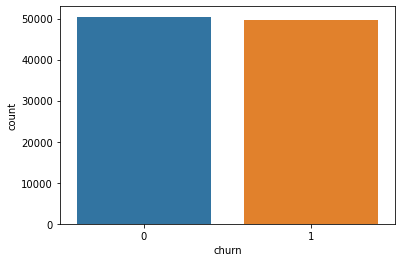

In [66]:
sns.countplot(x=full_data.churn)

Some of the columns within our data cannot be reliably imputed by our preprocessing, hence there are some columns still with missing data as seen below. We're hoping to use algorithms that can handle missing data since some of it may be MNAR with a lot of rows missing, but we'll take other steps to address the missingness if need be later. 

Text(0.5, 1.0, '% Data Missing in Each Column')

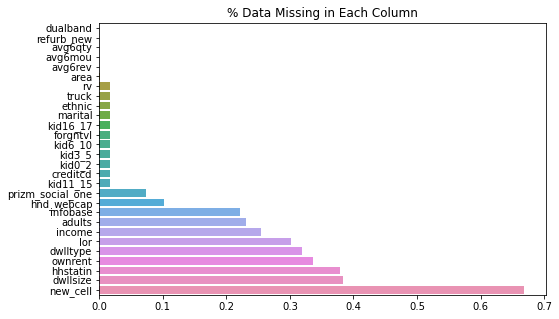

In [110]:
miss_data_cols = full_data.columns[full_data.isna().sum()>0]
pct_miss_data = (
    full_data[miss_data_cols].isna().sum()
    .sort_values()
    /full_data.shape[0]
)
plt.figure(figsize=(8,5))
ax = sns.barplot(x=num_miss_data,y=num_miss_data.index)
ax.set_title('% Data Missing in Each Column')

## Handling column descriptions

Since there is literally a hundred columns in this dataset, we may want to group similar columns together and analyze them group by group for an easier time. We just want a quick look so we won't use any complicated state of the art NLP methods, and stick with the tried and true, quick and dirty method of tfidf+kmeans clustering.

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import gensim
import spacy

In [116]:
#import custom graphing functions found in JeffUtils.py in the repository 
#to save on cluttering the notebook 
from JeffUtils import graph_cluster_wc, graph_elbow

column descriptions are scraped straight from the kaggle website via beautifulsoup. It's been packaged in this repository for convenience's sake. 

In [112]:
col_desc = pd.read_json('columnDescriptions.json',orient='index')[0].rename('col_desc').to_frame()
col_desc.index = col_desc.index.str.lower()
#pull out customer_id since it is just a primary key
col_desc = col_desc.drop(['customer_id'])
#pull out churn since it is our target variable
col_desc = col_desc.drop(['churn'])

In [115]:
#Remove stop words
col_desc['clean_desc'] = (
    col_desc['col_desc']
    .apply(gensim.parsing.preprocessing.remove_stopwords)
)

#Remove characters that are not decimals,
#not letters, and not white space
col_desc['clean_desc'] = (
    col_desc['clean_desc']
    .str.replace('[^a-zA-Z0-9_ \%]','')
)
#Replace double whitespace with single space
#created from operation above
col_desc['clean_desc'] = (
    col_desc['clean_desc']
    .str.replace('  ',' ')
)

In [123]:
nlp = spacy.load('en_core_web_sm')
col_desc['tokenized'] = col_desc['clean_desc'].apply(lambda x: [token.lemma_ for token in nlp(x)])
col_desc['lemmatized'] = col_desc['tokenized'].apply(lambda x: ' '.join(x))
tfidf = TfidfVectorizer()
tfidfMatrix = tfidf.fit_transform(col_desc['lemmatized'])

In [129]:
#Find the optimal n_clusters for K-Means between 5-16
kmeans = []
for i in range(5,16):
    km = KMeans(n_clusters=i,random_state=RANDOM_SEED)
    km.fit_predict(tfidfMatrix.toarray())
    kmeans.append((i,km.inertia_))
loss = pd.DataFrame(kmeans)[1].rename('loss')
loss.index = loss.index+5
elbow = graph_elbow(loss) 

c:\Users\JeffW\Anaconda3\envs\telecomChurn\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\JeffW\Anaconda3\envs\telecomChurn\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\JeffW\Anaconda3\envs\telecomChurn\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\JeffW\Anaconda3\envs\telecomChurn\lib\site-packages\sklearn\cluster\_kmea

# Univariate Analysis

## Numeric Features